In [159]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [5]:
spark = SparkSession.builder \
     .master("local") \
     .appName("Customer_Churn_Prediction") \
     .config("spark.some.config.option", "some-value") \
     .getOrCreate()


### Reading dataset

In [160]:
input_data = spark.read.csv('/home/hasan/DATA SET/customer churn prediction/customer_churn.csv', header=True)

In [161]:
input_data.count()

900

In [162]:
input_data.head()

Row(Names='Cameron Williams', Age='42.0', Total_Purchase='11066.8', Account_Manager='0', Years='7.22', Num_Sites='8.0', Onboard_date='2013-08-30 07:00:40', Location='10265 Elizabeth Mission Barkerburgh, AK 89518', Company='Harvey LLC', Churn='1')

In [163]:
input_data.show(5)

+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|
+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|2013-08-30 07:00:40|10265 Elizabeth M...|          Harvey LLC|    1|
|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|2013-08-13 00:38:46|6157 Frank Garden...|          Wilson PLC|    1|
|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|2016-06-29 06:20:07|1331 Keith Court ...|Miller, Johnson a...|    1|
|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|2014-04-22 12:43:12|13120 Daniel Moun...|           Smith Inc|    1|
|  Cynthia Norton|37.0|    

In [164]:
input_data.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Total_Purchase: string (nullable = true)
 |-- Account_Manager: string (nullable = true)
 |-- Years: string (nullable = true)
 |-- Num_Sites: string (nullable = true)
 |-- Onboard_date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: string (nullable = true)



### Handling missing data

In [165]:
from pyspark.sql.functions import isnan, when, count, col

In [166]:
input_data.select([count(when(col(c).isNull(), c)).alias(c) for c in input_data.columns]).toPandas().T.sort_values(0, ascending=False)


,0
Names,0
Age,0
Total_Purchase,0
Account_Manager,0
Years,0
Num_Sites,0
Onboard_date,0
Location,0
Company,0
Churn,0


### Changing datatype

In [167]:
from pyspark.sql.types import DoubleType, IntegerType

In [168]:
input_data = input_data.withColumn("Age", input_data["Age"].cast(IntegerType()))
input_data = input_data.withColumn("Total_Purchase", input_data["Total_Purchase"].cast(DoubleType()))
input_data = input_data.withColumn("Account_Manager", input_data["Account_Manager"].cast(IntegerType()))
input_data = input_data.withColumn("Years", input_data["Years"].cast(DoubleType()))
input_data = input_data.withColumn("Num_Sites", input_data["Num_Sites"].cast(IntegerType()))
input_data = input_data.withColumn("Churn", input_data["Churn"].cast(IntegerType()))


In [169]:
input_data.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: integer (nullable = true)
 |-- Onboard_date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



### VectorAssembler

In [170]:
featureAssembler = VectorAssembler(inputCols=['Age','Total_Purchase','Account_Manager','Years','Num_Sites'], outputCol='Independent Features')


In [171]:
output = featureAssembler.transform(input_data)
output.show(5)


+----------------+---+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+--------------------+
|           Names|Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|Independent Features|
+----------------+---+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+--------------------+
|Cameron Williams| 42|       11066.8|              0| 7.22|        8|2013-08-30 07:00:40|10265 Elizabeth M...|          Harvey LLC|    1|[42.0,11066.8,0.0...|
|   Kevin Mueller| 41|      11916.22|              0|  6.5|       11|2013-08-13 00:38:46|6157 Frank Garden...|          Wilson PLC|    1|[41.0,11916.22,0....|
|     Eric Lozano| 38|      12884.75|              0| 6.67|       12|2016-06-29 06:20:07|1331 Keith Court ...|Miller, Johnson a...|    1|[38.0,12884.75,0....|
|   Phillip White| 42|       8010.76|         

In [172]:
output.select('Independent Features').show()


+--------------------+
|Independent Features|
+--------------------+
|[42.0,11066.8,0.0...|
|[41.0,11916.22,0....|
|[38.0,12884.75,0....|
|[42.0,8010.76,0.0...|
|[37.0,9191.58,0.0...|
|[48.0,10356.02,0....|
|[44.0,11331.58,1....|
|[32.0,9885.12,1.0...|
|[43.0,14062.6,1.0...|
|[40.0,8066.94,1.0...|
|[30.0,11575.37,1....|
|[45.0,8771.02,1.0...|
|[45.0,8988.67,1.0...|
|[40.0,8283.32,1.0...|
|[41.0,6569.87,1.0...|
|[38.0,10494.82,1....|
|[45.0,8213.41,1.0...|
|[43.0,11226.88,0....|
|[53.0,5515.09,0.0...|
|[46.0,8046.4,1.0,...|
+--------------------+
only showing top 20 rows



In [173]:
output.columns

['Names',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Onboard_date',
 'Location',
 'Company',
 'Churn',
 'Independent Features']

In [174]:
output.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: integer (nullable = true)
 |-- Onboard_date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- Independent Features: vector (nullable = true)



### Selecting Features and Label data

In [175]:
feature_and_label_data = output.select('Independent Features', 'Churn')
feature_and_label_data.show(10)

+--------------------+-----+
|Independent Features|Churn|
+--------------------+-----+
|[42.0,11066.8,0.0...|    1|
|[41.0,11916.22,0....|    1|
|[38.0,12884.75,0....|    1|
|[42.0,8010.76,0.0...|    1|
|[37.0,9191.58,0.0...|    1|
|[48.0,10356.02,0....|    1|
|[44.0,11331.58,1....|    1|
|[32.0,9885.12,1.0...|    1|
|[43.0,14062.6,1.0...|    1|
|[40.0,8066.94,1.0...|    1|
+--------------------+-----+
only showing top 10 rows



### Dividing dataset

In [176]:
train_data, test_data = feature_and_label_data.randomSplit([0.75, 0.25])

In [177]:
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 681
Test Dataset Count: 219


### Model

In [178]:
regressor = LogisticRegression(featuresCol="Independent Features", labelCol="Churn", maxIter=10)
regressor = regressor.fit(train_data)


In [179]:
regressor.coefficients

DenseVector([-0.1102, -0.0002, 0.1218, 0.0661, 0.7972])

In [180]:
regressor.intercept

-2.731043393192411

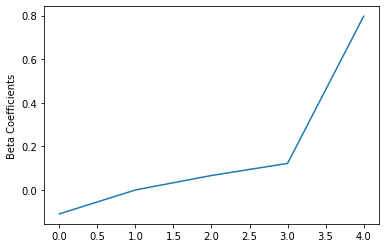

In [181]:
beta = np.sort(regressor.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()


### Prediction on Test data

In [182]:
prediction = regressor.transform(test_data)
prediction.show()


+--------------------+-----+--------------------+--------------------+----------+
|Independent Features|Churn|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[22.0,11254.38,1....|    0|[0.78445905925908...|[0.68664034667600...|       0.0|
|[25.0,9672.03,0.0...|    0|[0.85620051158228...|[0.70186622156110...|       0.0|
|[27.0,8628.8,1.0,...|    0|[1.53674028674587...|[0.82299035908940...|       0.0|
|[28.0,8670.98,0.0...|    0|[2.66172128137404...|[0.93472976062680...|       0.0|
|[29.0,5900.78,1.0...|    0|[0.34705597269156...|[0.58590347838107...|       0.0|
|[29.0,8688.17,1.0...|    1|[0.14917748080706...|[0.53722536160554...|       0.0|
|[29.0,10203.18,1....|    0|[1.26921897428201...|[0.78060901987332...|       0.0|
|[29.0,11274.46,1....|    0|[1.59503408126256...|[0.83132318469939...|       0.0|
|[29.0,13255.05,1....|    0|[1.99704322602022...|[0.88048628597262...|       0.0|
|[30.0,6744.87,0

### ROC Curve

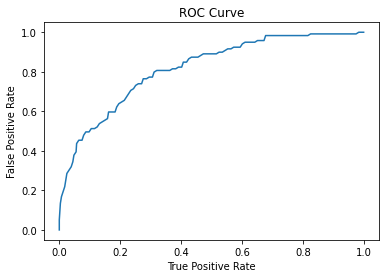

Training set areaUnderROC: 0.8155970573282696


In [183]:
train_summary = regressor.summary

roc = train_summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(train_summary.areaUnderROC))

### Precision and Recall

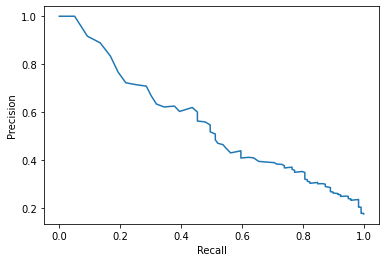

In [184]:
pr = train_summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
